# What causes flanking pairs to be reactive?

# Setup

## imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp, pearsonr, linregress, zscore
from sklearn.preprocessing import OneHotEncoder
import statsmodels.api as sm
from tabulate import tabulate

from dms_3d_features.plotting import (
    plot_pop_avg_from_row,
    publication_style_ax,
    plot_motif_boxplot_stripplot,
    format_small_plot,
)

## extra functions

## load data

In [2]:
DATA_PATH = "../data"

In [62]:
df_constructs = pd.read_json(f"{DATA_PATH}/raw-jsons/constructs/pdb_library_1.json")
df_constructs_nomod = pd.read_json(
    f"{DATA_PATH}/raw-jsons/constructs/pdb_library_nomod.json"
)
df = pd.read_json(f"{DATA_PATH}/raw-jsons/residues/pdb_library_1_residues.json")
df["ln_r_data"] = np.log(df["r_data"])
df["ln_r_data"].replace(-np.inf, -9.8, inplace=True)

df = df.query("r_data_outlier == False").copy()
df_wc = df.query("r_type == 'WC'").copy()

df_wc.sort_values("ln_r_data", inplace=True, ascending=False)
df_wc_high = df_wc.query("ln_r_data > -5.45").copy()
df_wc_high.sort_values("ln_r_data", inplace=True, ascending=False)

# TODO better understand how we got this data and howa to replicate it
# At the moment only look at flanking pairs
df_bp_details = pd.read_csv(f"../dms_3d_features/resources/csvs/wc_details.csv")
df_bp_details = df_bp_details.query("flanking_pairs == 'YES'")
df_bp_details["ln_r_data"] = np.log(df_bp_details["r_data"])

/opt/homebrew/Caskroom/miniconda/base/envs/py3/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/homebrew/Caskroom/miniconda/base/envs/py3/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


# plotting and analysis

## trends over all flanking nucleotides

### As are more reactive than Cs in flanking pairs

As are more reactive than Cs in flanking pairs even though there are more Cs flanking pairs in general

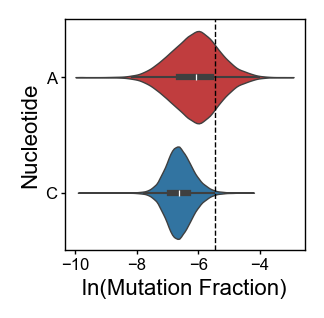

In [4]:
fig, ax = plt.subplots(figsize=(2.0, 1.5), dpi=200)
ax = sns.violinplot(
    data=df_wc,
    x="ln_r_data",
    y="r_nuc",
    hue="r_nuc",
    density_norm="width",
    palette=["tab:red", "tab:blue"],
    legend=False,
    linewidth=0.5,
    ax=ax,
)
ax.axvline(-5.45, color="black", linestyle="--", lw=0.5)
ax.set_ylabel("Nucleotide", labelpad=2)
ax.set_xlabel("ln(Mutation Fraction)", labelpad=2)
ax.set_xticks([-10, -8, -6, -4])
format_small_plot(ax)

#### There are 19% reactive As and 1% reactive Cs for flanking pairs

In [57]:
for r_nuc, g in df_wc.groupby("r_nuc"):
    g_sub = g.query("ln_r_data > -5.45")
    print(r_nuc, round(len(g_sub) / len(g) * 100, 2), len(g))

A 19.56 47652
C 1.01 52121


In [59]:
df_wc.groupby("r_nuc").agg({"ln_r_data": ["mean", "std", "count"]})

ln_r_data                 
           mean       std  count
r_nuc                           
A     -6.106741  0.787590  47652
C     -6.614291  0.452996  52121

#### if we consider only those with pdbs, there are still more reactive As

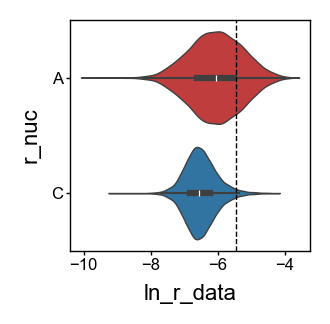

In [6]:
df_wc_pdb = df_wc.query("has_pdbs == True").copy()
fig, ax = plt.subplots(figsize=(2.0, 1.5), dpi=200)
ax = sns.violinplot(
    data=df_wc_pdb,
    x="ln_r_data",
    y="r_nuc",
    hue="r_nuc",
    density_norm="width",
    palette=["tab:red", "tab:blue"],
    legend=False,
    linewidth=0.5,
    ax=ax,
)
ax.axvline(-5.45, color="black", linestyle="--", lw=0.5),
ax.set_xticks([-10, -8, -6, -4])
publication_style_ax(ax)
format_small_plot(ax)

In [64]:
df_wc.query("has_pdbs == True").groupby(["m_sequence", "r_loc_pos"]).agg(
    {"ln_r_data": ["mean"]}
)

ln_r_data
                            mean
m_sequence   r_loc_pos          
AAAC&GCU     0         -5.875773
             3         -6.568015
AAACG&CUAU   0         -6.709681
             6         -6.943530
AAAG&CGAU    0         -6.732597
...                          ...
UUAUC&GUG    4         -6.632609
UUAUUU&AUUCA 7         -6.834947
             11        -5.832528
UUCUA&UUCUA  4         -6.902889
             10        -6.462907

[306 rows x 1 columns]

#### This trend is only seen in WC pairs not over all residues.

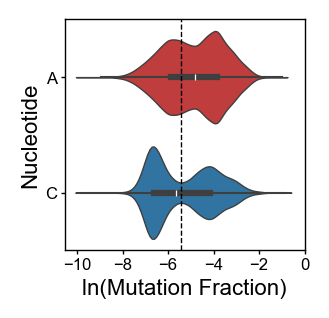

In [7]:
fig, ax = plt.subplots(figsize=(2.0, 1.5), dpi=200)
sns.violinplot(
    data=df,
    x="ln_r_data",
    y="r_nuc",
    hue="r_nuc",
    density_norm="width",
    palette=["tab:red", "tab:blue"],
    legend=False,
    linewidth=0.5,
    ax=ax,
)
ax.axvline(-5.45, color="black", linestyle="--", lw=0.5)
ax.set_ylabel("Nucleotide", labelpad=2)
ax.set_xlabel("ln(Mutation Fraction)", labelpad=2)
ax.set_xticks([-10, -8, -6, -4, -2, 0])
publication_style_ax(ax)
format_small_plot(ax)

## How do structural features of flanking pairs correlate with reactivity?

There doesnt seem to me much correlation between reactivity and the number of extra nucleotides in flanking pairs

In [8]:
def get_pearson_r2_correlations(df, target_column, feature_columns):
    """
    Calculate Pearson R^2 correlations between a target column and specified feature columns.

    Args:
    df (pandas.DataFrame): The input DataFrame
    target_column (str): The name of the target column
    feature_columns (list): List of feature column names to correlate with the target

    Returns:
    dict: A dictionary with feature names as keys and their R^2 values as values
    """
    from scipy import stats

    correlations = {}
    for feature in feature_columns:
        r, _ = stats.pearsonr(df[target_column], df[feature])
        r2 = r**2
        correlations[feature] = r2

    return correlations


def print_feature_correlations(df):
    feature_columns = [
        "shear",
        "stretch",
        "stagger",
        "buckle",
        "propeller",
        "opening",
        "rmsd_from_ideal",
    ]
    correlations = get_pearson_r2_correlations(df, "r_data", feature_columns)

    # Prepare data for tabulate
    table_data = [[feature, f"{r2:.3f}"] for feature, r2 in correlations.items()]
    headers = ["Feature", "R^2 with ln_r_data"]

    # Print the results using tabulate
    print(tabulate(table_data, headers=headers, tablefmt="pipe"))

### no parameters are strongly correlated with reactivity for any base pair type

In [9]:
print_feature_correlations(df_bp_details)

| Feature         |   R^2 with ln_r_data |
|:----------------|---------------------:|
| shear           |                0     |
| stretch         |                0.003 |
| stagger         |                0.002 |
| buckle          |                0.002 |
| propeller       |                0     |
| opening         |                0.001 |
| rmsd_from_ideal |                0.004 |


In [10]:
df_bp_details_sub = df_bp_details.query("bp == 'AU'").copy()
print_feature_correlations(df_bp_details_sub)

| Feature         |   R^2 with ln_r_data |
|:----------------|---------------------:|
| shear           |                0.006 |
| stretch         |                0.001 |
| stagger         |                0.001 |
| buckle          |                0.001 |
| propeller       |                0.007 |
| opening         |                0.001 |
| rmsd_from_ideal |                0.01  |


In [11]:
df_bp_details_sub = df_bp_details.query("bp == 'UA'").copy()
print_feature_correlations(df_bp_details_sub)

| Feature         |   R^2 with ln_r_data |
|:----------------|---------------------:|
| shear           |                0     |
| stretch         |                0     |
| stagger         |                0.052 |
| buckle          |                0.001 |
| propeller       |                0.005 |
| opening         |                0.017 |
| rmsd_from_ideal |                0.002 |


In [12]:
df_bp_details_sub = df_bp_details.query("bp == 'CG'").copy()
print_feature_correlations(df_bp_details_sub)

| Feature         |   R^2 with ln_r_data |
|:----------------|---------------------:|
| shear           |                0.003 |
| stretch         |                0     |
| stagger         |                0.001 |
| buckle          |                0     |
| propeller       |                0     |
| opening         |                0.003 |
| rmsd_from_ideal |                0.002 |


In [13]:
df_bp_details_sub = df_bp_details.query("bp == 'GC'").copy()
print_feature_correlations(df_bp_details_sub)

| Feature         |   R^2 with ln_r_data |
|:----------------|---------------------:|
| shear           |                0.001 |
| stretch         |                0.001 |
| stagger         |                0     |
| buckle          |                0.002 |
| propeller       |                0.001 |
| opening         |                0     |
| rmsd_from_ideal |                0.002 |


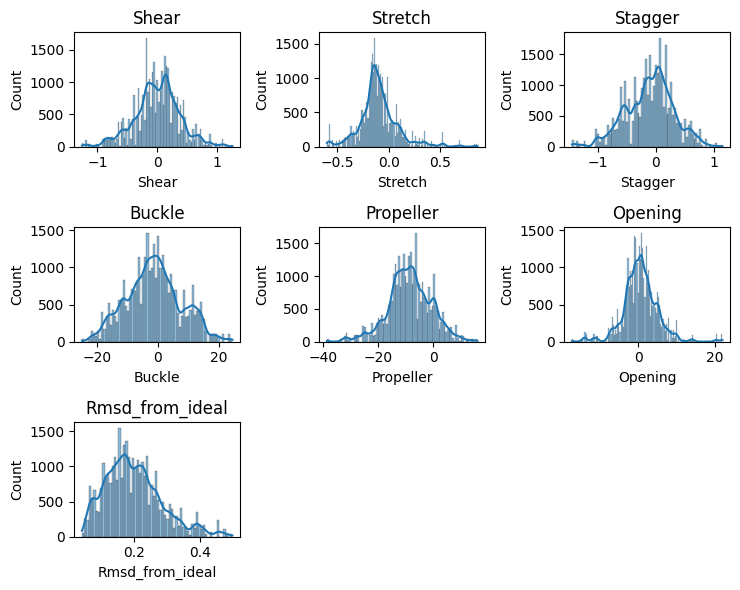

In [14]:
def plot_feature_histograms(df, feature_columns):
    n_features = len(feature_columns)
    n_cols = 3
    n_rows = (n_features + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(7.5, 2.0 * n_rows))
    for idx, feature in enumerate(feature_columns):
        row = idx // n_cols
        col = idx % n_cols
        ax = axes[row, col] if n_rows > 1 else axes[col]

        sns.histplot(data=df, x=feature, kde=True, ax=ax)
        ax.set_title(feature.capitalize())
        ax.set_xlabel(feature.capitalize())
        ax.set_ylabel("Count")

    # Remove any unused subplots
    for idx in range(n_features, n_rows * n_cols):
        row = idx // n_cols
        col = idx % n_cols
        fig.delaxes(axes[row, col] if n_rows > 1 else axes[col])


feature_columns = [
    "shear",
    "stretch",
    "stagger",
    "buckle",
    "propeller",
    "opening",
    "rmsd_from_ideal",
]
# Plot histograms for all base pairs
plot_feature_histograms(df_bp_details, feature_columns)
plt.tight_layout()

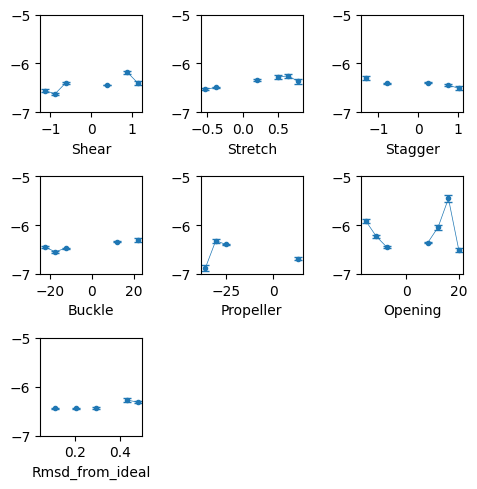

In [15]:
import warnings


def bin_reactivity_vs_feature(df, feature, n_bins=10):
    df = df.copy()
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=RuntimeWarning)
        df["ln_r_data"] = np.log(df["r_data"])
    df["bin"] = pd.cut(df[feature], bins=n_bins)

    binned_data = (
        df.groupby("bin")["ln_r_data"].agg(["mean", "std", "count"]).reset_index()
    )
    binned_data["bin_center"] = binned_data["bin"].apply(lambda x: x.mid)

    return binned_data


def plot_binned_reactivity(binned_data, feature, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))

    ax.errorbar(
        binned_data["bin_center"],
        binned_data["mean"],
        yerr=binned_data["std"] / np.sqrt(binned_data["count"]),
        fmt="o-",
        capsize=3,
        ms=3,
        lw=0.5,
    )

    ax.set_xlabel(feature.capitalize())
    return ax


# Create subplots for each feature
fig, axes = plt.subplots(3, 3, figsize=(5.0, 5.0))
axes = axes.flatten()

for i, feature in enumerate(feature_columns):
    binned_data = bin_reactivity_vs_feature(df_bp_details, feature)
    plot_binned_reactivity(binned_data, feature, ax=axes[i])
    axes[i].set_ylim([-7, -5])

# Remove any unused subplots
for i in range(len(feature_columns), 9):
    fig.delaxes(axes[i])
plt.tight_layout()

In [16]:
def bin_reactivity_vs_feature(df, feature, n_bins=10):
    df = df.copy()
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=RuntimeWarning)
        df["ln_r_data"] = np.log(df["r_data"])
    df["bin"] = pd.cut(df[feature], bins=n_bins)

    binned_data = (
        df.groupby("bin")["ln_r_data"].agg(["mean", "std", "count"]).reset_index()
    )
    binned_data["bin_center"] = binned_data["bin"].apply(lambda x: x.mid)

    return binned_data


def create_reactivity_table(df, feature_columns, n_bins=10):
    tables = []
    for feature in feature_columns:
        binned_data = bin_reactivity_vs_feature(df, feature, n_bins)
        table = binned_data[["bin", "mean", "std", "count"]]
        table.columns = [
            f"{feature} bin",
            "Mean ln(reactivity)",
            "Std ln(reactivity)",
            "Count",
        ]
        table = table.round(3)
        tables.append(table)

    return tables


# Create tables for each feature
tables = create_reactivity_table(df_bp_details, feature_columns)

# Display tables using tabulate
for i, table in enumerate(tables):
    print(f"\nFeature: {feature_columns[i]}")
    print(tabulate(table, headers="keys", tablefmt="pipe", showindex=False))


Feature: shear
| shear bin        |   Mean ln(reactivity) |   Std ln(reactivity) |   Count |
|:-----------------|----------------------:|---------------------:|--------:|
| (-1.263, -1.008] |                -6.558 |                0.485 |     245 |
| (-1.008, -0.756] |                -6.618 |                0.517 |     827 |
| (-0.756, -0.504] |                -6.401 |                0.689 |    2073 |
| (-0.504, -0.252] |               nan     |              nan     |    3753 |
| (-0.252, 0.0]    |               nan     |              nan     |    9339 |
| (0.0, 0.252]     |               nan     |              nan     |    9320 |
| (0.252, 0.504]   |                -6.442 |                0.569 |    4945 |
| (0.504, 0.756]   |               nan     |              nan     |    1674 |
| (0.756, 1.008]   |                -6.183 |                0.721 |     462 |
| (1.008, 1.26]    |                -6.399 |                0.614 |     220 |

Feature: stretch
| stretch bin      |   Mean ln

### examples of pdbs with high reactivity

In [17]:
df_bp_details.sort_values("ln_r_data", ascending=False, inplace=True)

df_bp_details.head(30)

,m_sequence,bp,pdb_r_pos1,pdb_r_pos2,rmsd_from_ideal,shear,stretch,stagger,buckle,propeller,opening,r_data,flanking_pairs,ln_r_data
29251,GGGA&UAAC,UA,11,6,0.346129,-0.60,-0.14,0.33,-6.20,-32.27,-14.11,0.02423,YES,-3.720164
31852,UAUGUAG&UGAAA,UA,3,18,0.177916,0.04,0.07,0.55,-0.65,-9.65,2.00,0.02305,YES,-3.770090
31772,UAUGUAG&UGAAA,UA,3,18,0.177916,0.04,0.07,0.55,-0.65,-9.65,2.00,0.02304,YES,-3.770523
31834,UAUGUAG&UGAAA,UA,3,18,0.177916,0.04,0.07,0.55,-0.65,-9.65,2.00,0.02232,YES,-3.802272
10136,CCGUG&CG,GC,7,12,0.212206,-0.56,-0.10,-0.52,-6.14,-3.44,9.69,0.02124,YES,-3.851869
2852,ACAUG&CU,AU,3,13,0.103032,0.02,-0.10,0.08,4.61,-11.34,0.99,0.02117,YES,-3.855170
31798,UAUGUAG&UGAAA,UA,3,18,0.177916,0.04,0.07,0.55,-0.65,-9.65,2.00,0.02108,YES,-3.859431
2824,ACAUG&CU,AU,3,13,0.103032,0.02,-0.10,0.08,4.61,-11.34,0.99,0.02072,YES,-3.876656
30372,UAAG&CA,AU,12,3,0.107130,-0.07,-0.24,0.09,5.40,-14.27,6.42,0.01996,YES,-3.914025
31014,UACA&UUAA,AU,14,3,0.227118,-0.10,-0.12,-0.33,-2.14,2.73,2.87,0.01986,YES,-3.919048


In [18]:
df_bp_details.tail(100)

,m_sequence,bp,pdb_r_pos1,pdb_r_pos2,rmsd_from_ideal,shear,stretch,stagger,buckle,propeller,opening,r_data,flanking_pairs,ln_r_data
33683,UUAUUU&AUUCA,UA,8,13,0.128218,-0.06,-0.13,0.15,1.00,-6.58,7.94,0.00033,YES,-8.016418
9581,CCC&GUG,GC,10,5,0.290991,-0.56,-0.22,-1.37,-21.53,-7.59,-2.87,0.00033,YES,-8.016418
9655,CCC&GUG,GC,10,5,0.456022,0.46,0.03,-0.66,-20.30,-38.53,2.23,0.00033,YES,-8.016418
6272,AUCU&AUUU,UA,14,3,0.169110,-0.08,-0.13,0.56,4.00,-16.07,-3.02,0.00033,YES,-8.016418
31335,UAC&GA,CG,5,10,0.159367,0.20,-0.16,0.30,-8.93,0.23,2.32,0.00032,YES,-8.047190
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1110,AAC&GCU,UA,12,3,0.250992,-0.30,0.10,-0.47,16.71,-6.29,0.11,0.00000,YES,-inf
6210,AUCU&AUUU,UA,14,3,0.169110,-0.08,-0.13,0.56,4.00,-16.07,-3.02,0.00000,YES,-inf
195,AAACG&CUAU,UA,15,3,0.328334,-0.01,-0.12,-0.38,-9.71,8.11,0.15,0.00000,YES,-inf
2356,AAU&ACU,AU,10,5,0.065119,0.00,-0.05,0.03,-4.71,-16.30,4.68,0.00000,YES,-inf


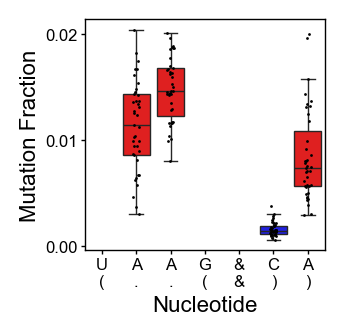

In [19]:
fig, ax = plt.subplots(figsize=(2.0, 1.5), dpi=200)
plot_motif_boxplot_stripplot(
    df.query("m_sequence == 'UAAG&CA'"), ax=ax, show_structure=True
)
format_small_plot(ax)

## How does the reactivity for A and C flanking pairs compare compare by different junction topologies?

### looking at all topologies

General trends are that for topologies that are more uneven are more reactive on average than those are are even<br><br>
This holds true for both As and Cs although the effect is much stronger for As

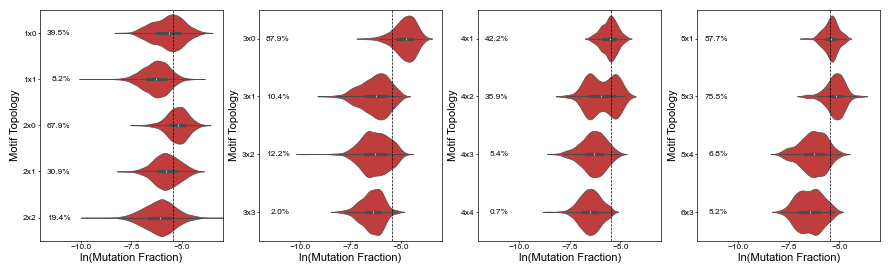

In [20]:
def plot_violins_by_groups(
    df, group_col, x_col, y_col, color, n_panels=2, figsize=(3.5, 3), dpi=100
):
    df = df.copy()
    df.sort_values(group_col, inplace=True, ascending=True)

    # Split groups into n_panels
    groups = df[group_col].unique()
    group_splits = np.array_split(groups, n_panels)

    # Create subplots
    fig, axes = plt.subplots(
        1, n_panels, figsize=(figsize[0] * n_panels, figsize[1]), dpi=dpi
    )
    if n_panels == 1:
        axes = [axes]

    for i, (ax, group_split) in enumerate(zip(axes, group_splits)):
        sns.violinplot(
            data=df[df[group_col].isin(group_split)],
            x=x_col,
            y=group_col,
            density_norm="width",
            color=color,
            ax=ax,
            linewidth=0.5,
        )
        ax.axvline(-5.45, color="black", linestyle="--", lw=0.5)
        ax.set_ylabel("Motif Topology", labelpad=2)
        ax.set_xlabel("ln(Mutation Fraction)", labelpad=2)
        ax.set_xlim(-12, -3)
        # Calculate and add percentage labels
        for idx, group in enumerate(group_split):
            group_data = df[df[group_col] == group][x_col]
            percent_over = (group_data > -5.45).mean() * 100
            ax.text(
                ax.get_xlim()[0] + 1.5,
                idx,
                f"{percent_over:.1f}%",
                va="center",
                ha="right",
                fontsize=10,
            )

        format_small_plot(ax)


# Usage
df_pos = df_wc.query("r_nuc == 'A'").copy()
plot_violins_by_groups(df_pos, "m_token", "ln_r_data", "m_token", "tab:red", n_panels=4)

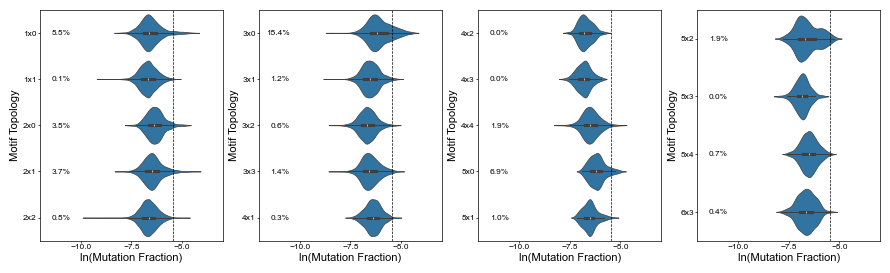

In [21]:
df_pos = df_wc.query("r_nuc == 'C'").copy()
plot_violins_by_groups(
    df_pos, "m_token", "ln_r_data", "m_token", "tab:blue", n_panels=4
)

In [22]:
# Calculate percentage of entries over -5.45 for each m_token and total count
def calculate_and_format_percent_over_threshold(df_wc):
    df_wc_percent = (
        df_wc.groupby("m_token")
        .agg(
            {
                "ln_r_data": [
                    (
                        "percent_over_threshold",
                        lambda x: round((x > -5.45).mean() * 100, 2),
                    ),
                    ("total_entries", "count"),
                ]
            }
        )
        .reset_index()
    )
    # Format the table with headers and better styling
    table = tabulate(
        df_wc_percent,
        headers=["junction topology", "percent over threshold", "total entries"],
        tablefmt="pretty",
        floatfmt=".2f",
        numalign="right",
        showindex=False,
    )
    return table


df_pos = df_wc.query("r_nuc == 'A'").copy()
print("A reactivity of flanking As by junction topology")
print(calculate_and_format_percent_over_threshold(df_pos))
# Sort the dataframe by percentage in descending order

A reactivity of flanking As by junction topology
+-------------------+------------------------+---------------+
| junction topology | percent over threshold | total entries |
+-------------------+------------------------+---------------+
|        1x0        |         39.53          |      387      |
|        1x1        |          8.18          |     2434      |
|        2x0        |         67.89          |      383      |
|        2x1        |         30.86          |      324      |
|        2x2        |         19.43          |     40904     |
|        3x0        |         87.93          |      174      |
|        3x1        |         10.41          |      538      |
|        3x2        |         12.16          |      510      |
|        3x3        |          1.95          |      307      |
|        4x1        |         42.16          |      204      |
|        4x2        |         35.92          |      103      |
|        4x3        |          5.37          |      410      |
|     

In [23]:
df_pos = df_wc.query("r_nuc == 'C'").copy()
print("A reactivity of flanking Cs by junction topology")
print(calculate_and_format_percent_over_threshold(df_pos))

A reactivity of flanking Cs by junction topology
+-------------------+------------------------+---------------+
| junction topology | percent over threshold | total entries |
+-------------------+------------------------+---------------+
|        1x0        |          5.46          |      549      |
|        1x1        |          0.13          |     2375      |
|        2x0        |          3.5           |      257      |
|        2x1        |          3.7           |     2083      |
|        2x2        |          0.54          |     39514     |
|        3x0        |         15.43          |      784      |
|        3x1        |          1.17          |      857      |
|        3x2        |          0.56          |     1430      |
|        3x3        |          1.39          |     1221      |
|        4x1        |          0.33          |      304      |
|        4x2        |          0.0           |      152      |
|        4x3        |          0.0           |      102      |
|     

### compare number of extra nucleotides on each side which appears to be correlated with reactivity in flanking pairs

(<Figure size 400x300 with 1 Axes>,
 <Axes: xlabel='ln(Mutation Fraction)', ylabel='Diff. in num nucleotides'>)

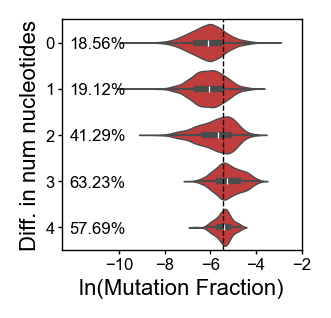

In [24]:
def plot_side_diff_violinplot(df_pos, color="tab:red"):
    df_pos["side_diff"] = [
        abs(int(x.split("x")[0]) - int(x.split("x")[1])) for x in df_pos["m_token"]
    ]
    df_pos["side_diff"] = df_pos["side_diff"].astype(str)
    df_pos.sort_values("side_diff", inplace=True, ascending=True)

    # Calculate percentage over threshold for each side_diff
    percentages = (
        df_pos.groupby("side_diff")
        .apply(lambda x: (x["ln_r_data"] > -5.45).mean() * 100)
        .round(2)
    )

    fig, ax = plt.subplots(figsize=(2.0, 1.5), dpi=200)
    ax = sns.violinplot(
        data=df_pos,
        x="ln_r_data",
        y="side_diff",
        density_norm="width",
        color=color,
        linewidth=0.5,
        ax=ax,
    )
    ax.axvline(-5.45, color="black", linestyle="--", lw=0.5)
    ax.set_xlim(-12.5, -3)
    ax.set_xticks([-10, -8, -6, -4, -2])
    ax.set_xlabel("ln(Mutation Fraction)", labelpad=2)
    ax.set_ylabel("Diff. in num nucleotides", labelpad=2)
    # Add percentage labels
    for i, (side_diff, percentage) in enumerate(percentages.items()):
        ax.text(-9.7, i + 0.03, f"{percentage:.2f}%", va="center", ha="right")
    format_small_plot(ax)

    return fig, ax


df_pos = df_wc.query("r_nuc == 'A' and m_token != '6x3'").copy()
plot_side_diff_violinplot(df_pos)

(<Figure size 400x300 with 1 Axes>,
 <Axes: xlabel='ln(Mutation Fraction)', ylabel='Diff. in num nucleotides'>)

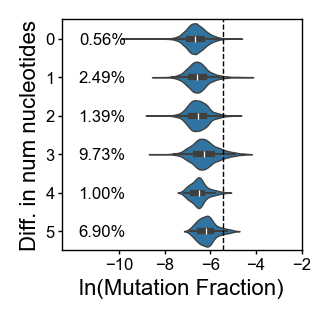

In [25]:
df_pos = df_wc.query("r_nuc == 'C' and m_token != '6x3'").copy()
plot_side_diff_violinplot(df_pos, color="tab:blue")

## How does sequence and stacking correlate with reactivity of flanking residues

In [26]:
def plot_violinplot_with_percentages(df, y_column, color="tab:red", ax=None):
    # Calculate percentages
    percentages = (
        df.groupby(y_column)
        .apply(lambda x: (x["ln_r_data"] > -5.45).mean() * 100)
        .round(2)
    )

    # Sort y_column values by percentage
    sorted_y_values = percentages.sort_values(ascending=False).index

    if ax is None:
        fig, ax = plt.subplots(figsize=(2.0, 1.5), dpi=200)
    else:
        fig = ax.figure

    sns.violinplot(
        data=df,
        x="ln_r_data",
        y=y_column,
        density_norm="width",
        color=color,
        linewidth=0.5,
        order=sorted_y_values,
        ax=ax,
    )
    ax.axvline(-5.45, color="black", linestyle="--", lw=0.5)

    # Add percentage labels
    for i, y_value in enumerate(sorted_y_values):
        ax.text(-9.7, i, f"{percentages[y_value]:.2f}%", va="center", ha="right")

    ax.set_xlim(-12.5, -3)
    ax.set_xticks([-10, -8, -6, -4, -2])
    ax.set_xlabel("ln(Mutation Fraction)", labelpad=2)
    y_label = ""
    if y_column == "p3_res":
        y_label = "3' Nucleotide"
    elif y_column == "p5_res":
        y_label = "5' Nucleotide"
    elif y_column == "r_stack":
        y_label = "Nucleotide Stack"
    ax.set_ylabel(y_label, labelpad=2)
    format_small_plot(ax)

    return fig, ax

In [27]:
df_bp_details.sort_values("ln_r_data", ascending=False)

,m_sequence,bp,pdb_r_pos1,pdb_r_pos2,rmsd_from_ideal,shear,stretch,stagger,buckle,propeller,opening,r_data,flanking_pairs,ln_r_data
29251,GGGA&UAAC,UA,11,6,0.346129,-0.60,-0.14,0.33,-6.20,-32.27,-14.11,0.02423,YES,-3.720164
31852,UAUGUAG&UGAAA,UA,3,18,0.177916,0.04,0.07,0.55,-0.65,-9.65,2.00,0.02305,YES,-3.770090
31772,UAUGUAG&UGAAA,UA,3,18,0.177916,0.04,0.07,0.55,-0.65,-9.65,2.00,0.02304,YES,-3.770523
31834,UAUGUAG&UGAAA,UA,3,18,0.177916,0.04,0.07,0.55,-0.65,-9.65,2.00,0.02232,YES,-3.802272
10136,CCGUG&CG,GC,7,12,0.212206,-0.56,-0.10,-0.52,-6.14,-3.44,9.69,0.02124,YES,-3.851869
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6229,AUCU&AUUU,UA,14,3,0.169110,-0.08,-0.13,0.56,4.00,-16.07,-3.02,0.00000,YES,-inf
403,AAACG&CUAU,UA,15,3,0.255976,0.65,-0.30,-0.38,8.86,-4.04,5.79,0.00000,YES,-inf
1190,AAC&GCU,UA,12,3,0.400050,-0.27,0.41,-1.02,15.67,0.58,2.82,0.00000,YES,-inf
2110,AAU&ACU,AU,10,5,0.150139,-0.40,-0.26,0.04,-3.09,-8.60,5.93,0.00000,YES,-inf


### the effect on As

(<Figure size 400x300 with 1 Axes>,
 <Axes: xlabel='ln(Mutation Fraction)', ylabel="5' Nucleotide">)

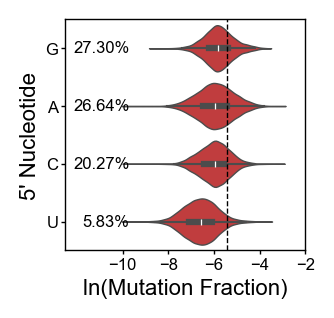

In [28]:
df_pos = df_wc.query("r_nuc == 'A'").copy()
plot_violinplot_with_percentages(df_pos, y_column="p5_res", color="tab:red")

(<Figure size 400x300 with 1 Axes>,
 <Axes: xlabel='ln(Mutation Fraction)', ylabel="3' Nucleotide">)

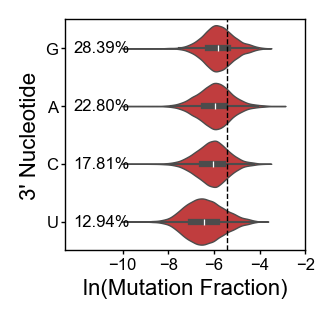

In [29]:
plot_violinplot_with_percentages(df_pos, y_column="p3_res", color="tab:red")

(<Figure size 400x700 with 1 Axes>,
 <Axes: xlabel='ln(Mutation Fraction)', ylabel='Nucleotide Stack'>)

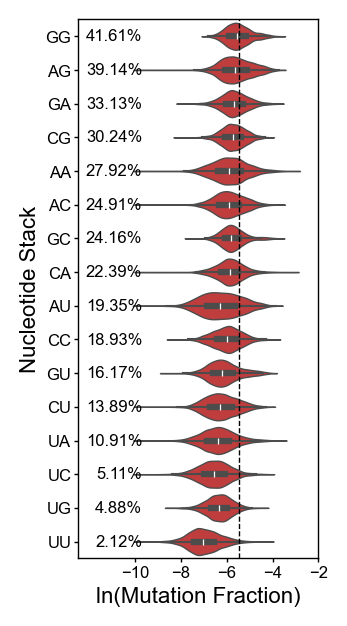

In [30]:
df_pos = df_wc.query("r_nuc == 'A'").copy()
fig, ax = plt.subplots(figsize=(2.0, 3.5), dpi=200)
plot_violinplot_with_percentages(df_pos, y_column="r_stack", color="tab:red", ax=ax)

(<Figure size 400x300 with 1 Axes>,
 <Axes: xlabel='ln(Mutation Fraction)', ylabel="5' Nucleotide">)

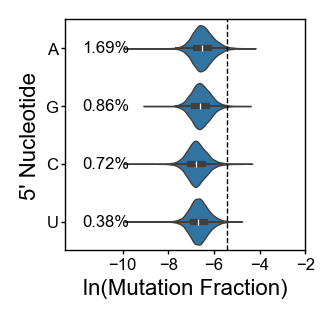

In [31]:
df_pos = df_wc.query("r_nuc == 'C'").copy()
plot_violinplot_with_percentages(df_pos, y_column="p5_res", color="tab:blue")

(<Figure size 400x300 with 1 Axes>,
 <Axes: xlabel='ln(Mutation Fraction)', ylabel="3' Nucleotide">)

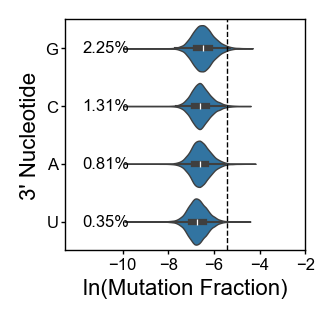

In [32]:
df_pos = df_wc.query("r_nuc == 'C'").copy()
plot_violinplot_with_percentages(df_pos, y_column="p3_res", color="tab:blue")

(<Figure size 400x600 with 1 Axes>,
 <Axes: xlabel='ln(Mutation Fraction)', ylabel='Nucleotide Stack'>)

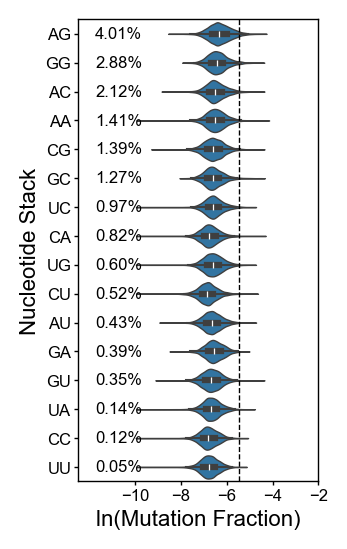

In [33]:
df_pos = df_wc.query("r_nuc == 'C'").copy()
fig, ax = plt.subplots(figsize=(2.0, 3.0), dpi=200)
plot_violinplot_with_percentages(df_pos, y_column="r_stack", color="tab:blue", ax=ax)

In [34]:
def create_summary_table(df, y_column):
    # Calculate percentages and counts
    summary = []
    for y_value in df[y_column].unique():
        group = df[df[y_column] == y_value]
        percent_over = (group["ln_r_data"] > -5.45).mean() * 100
        count = len(group)
        summary.append([y_value, f"{percent_over:.2f}%", count])

    # Sort by percentage descending
    summary.sort(key=lambda x: float(x[1][:-1]), reverse=True)

    # Create table
    headers = [y_column, "% Over -5.45", "Count"]
    table = tabulate(summary, headers=headers, tablefmt="pipe", floatfmt=".2f")

    print(f"Summary table for {y_column}:")
    print(table)


# Example usage:
df_pos = df_wc.query("r_nuc == 'A'").copy()
create_summary_table(df_pos, "p3_res")

Summary table for p3_res:
| p3_res   | % Over -5.45   |   Count |
|:---------|:---------------|--------:|
| G        | 28.39%         |    8239 |
| A        | 22.80%         |   13320 |
| C        | 17.81%         |   11665 |
| U        | 12.94%         |   14428 |


## look at the most reactive sequences

In [35]:
first_10_unique = df_wc_high.drop_duplicates(subset="m_sequence", keep="first").head(10)

# Calculate average reactivity for each m_sequence
avg_reactivity = df_wc_high.groupby("m_sequence")["r_data"].mean().reset_index()

# Merge with first_10_unique to get the position information
result = first_10_unique.merge(avg_reactivity, on="m_sequence")

# Create a table with m_sequence, position, and average reactivity
table_data = result[["m_sequence", "r_loc_pos", "r_data_y"]].values.tolist()

# Use tabulate to create a formatted table
print(
    tabulate(
        table_data,
        headers=["m_sequence", "Position", "Avg Reactivity"],
        tablefmt="grid",
    )
)

+--------------+------------+------------------+
| m_sequence   |   Position |   Avg Reactivity |
+==============+============+==================+
| AAUG&CCAU    |          0 |       0.0209033  |
+--------------+------------+------------------+
| AACG&CCAU    |          0 |       0.01488    |
+--------------+------------+------------------+
| AAUA&UCAU    |          0 |       0.0104289  |
+--------------+------------+------------------+
| AAUC&GCAU    |          0 |       0.0109958  |
+--------------+------------+------------------+
| AAUG&CUGU    |          0 |       0.0128355  |
+--------------+------------+------------------+
| AACA&UCAU    |          0 |       0.0102059  |
+--------------+------------+------------------+
| UCAA&UGAA    |          8 |       0.00863218 |
+--------------+------------+------------------+
| CAAA&UCAG    |          3 |       0.0101071  |
+--------------+------------+------------------+
| GUGA&UAUC    |          3 |       0.0128456  |
+--------------+----

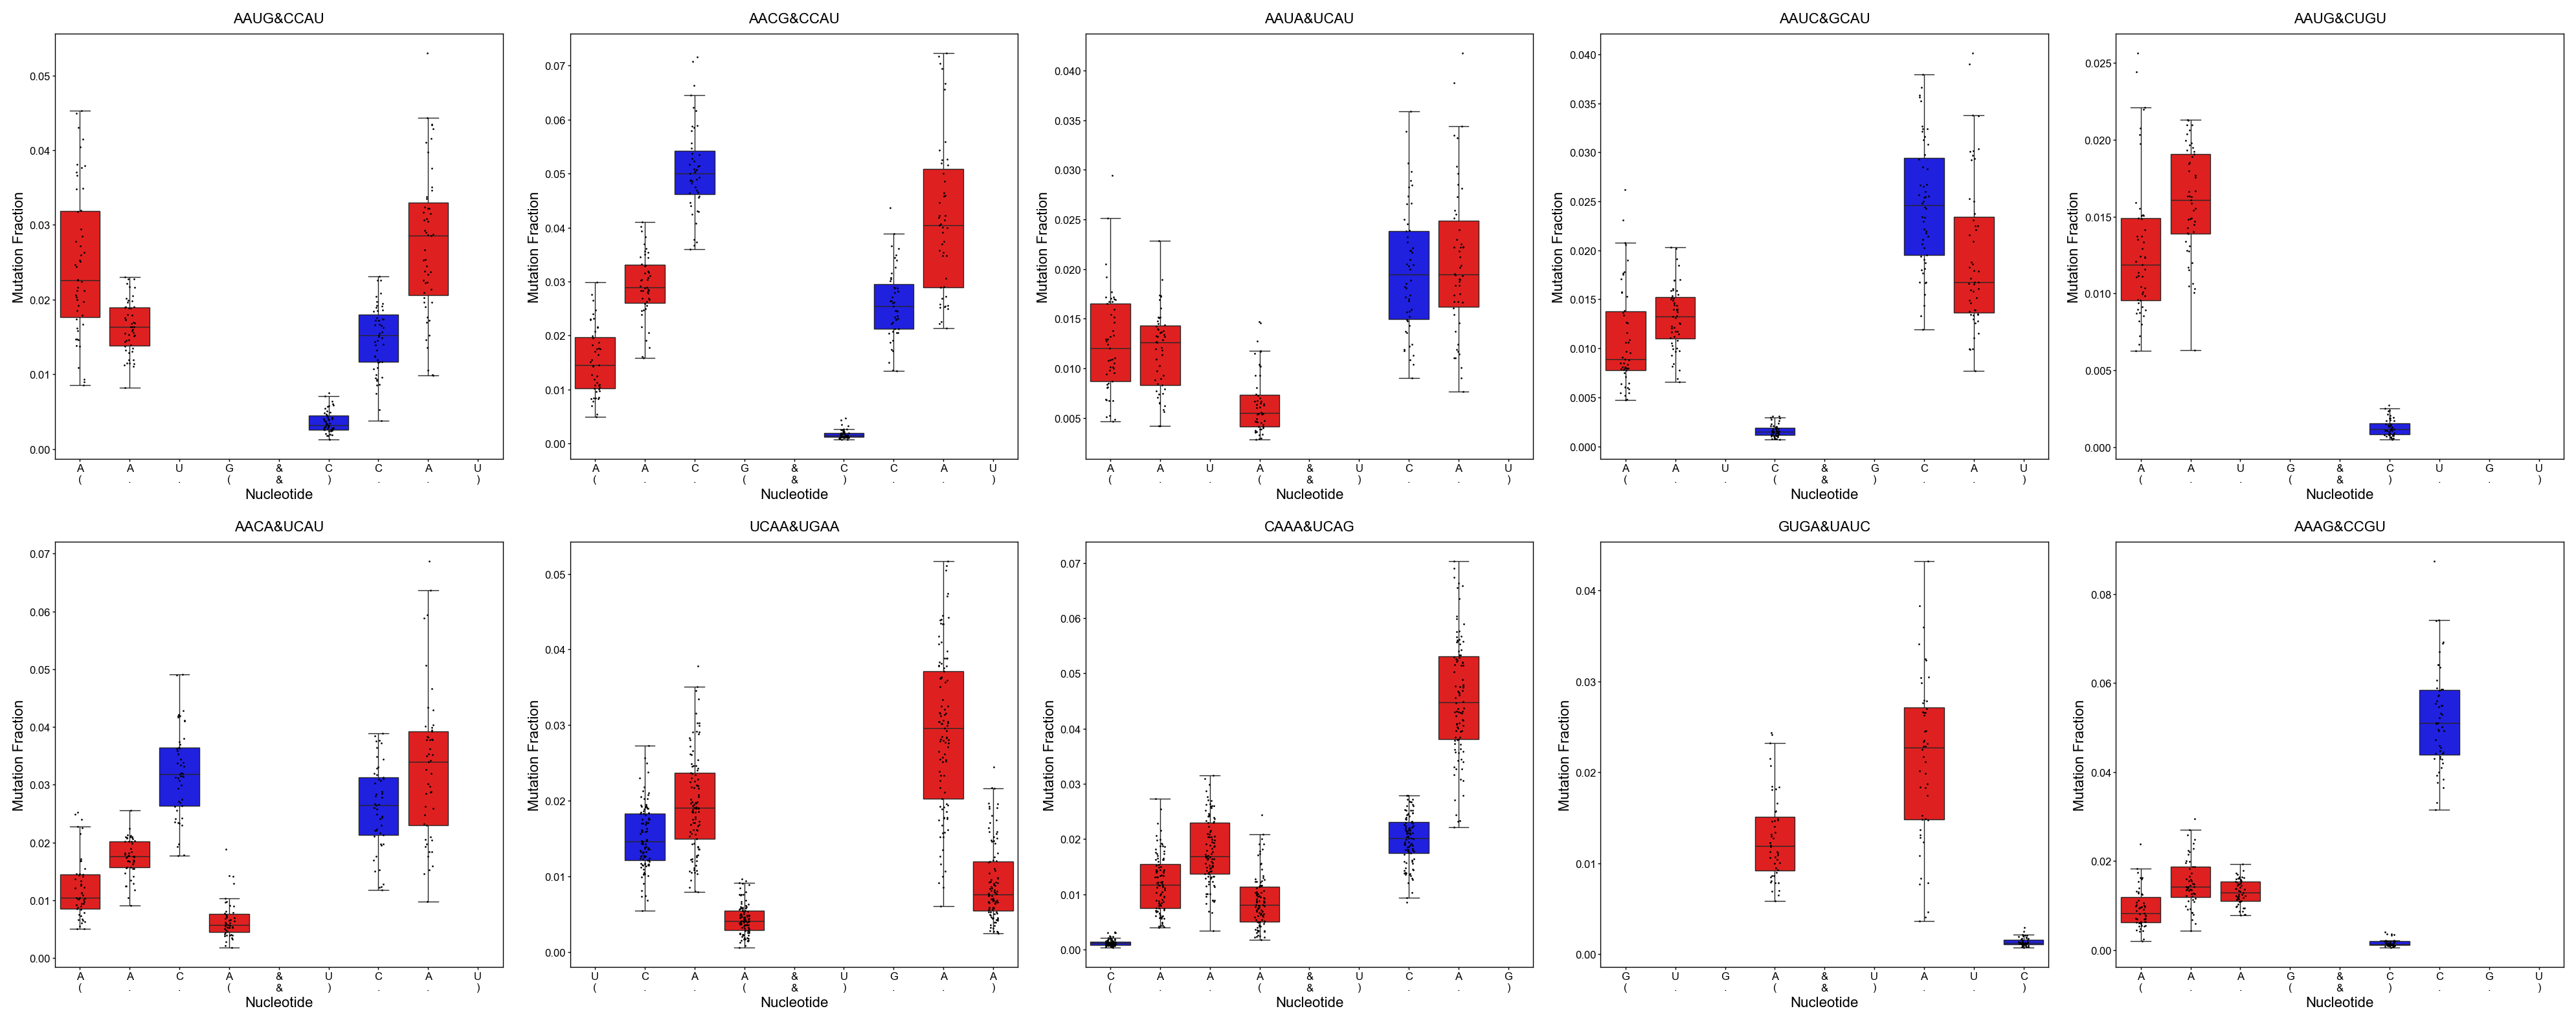

In [36]:
fig, axes = plt.subplots(2, 5, figsize=(20, 8), dpi=200)
axes = axes.flatten()

top_10_sequences = first_10_unique["m_sequence"].tolist()

for i, sequence in enumerate(top_10_sequences):
    if i < len(axes):  # Add this check to avoid index out of bounds error
        ax = axes[i]
        plot_motif_boxplot_stripplot(
            df.query(f"m_sequence == '{sequence}'"), ax=ax, show_structure=True
        )
        format_small_plot(ax)
        ax.set_title(sequence, fontsize=8)

# Remove any unused subplots
for j in range(len(top_10_sequences), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()  # Adjust the layout to prevent overlapping

In [37]:
df_wc_high_pdb = df_wc_high.query("has_pdbs == True").copy()
first_10_unique = df_wc_high_pdb.drop_duplicates(
    subset="m_sequence", keep="first"
).head(10)

# Calculate average reactivity for each m_sequence
avg_reactivity = df_wc_high.groupby("m_sequence")["r_data"].mean().reset_index()

# Merge with first_10_unique to get the position information
result = first_10_unique.merge(avg_reactivity, on="m_sequence")

# Create a table with m_sequence, position, and average reactivity
table_data = result[["m_sequence", "r_loc_pos", "r_data_y"]].values.tolist()

# Use tabulate to create a formatted table
print(
    tabulate(
        table_data,
        headers=["m_sequence", "Position", "Avg Reactivity"],
        tablefmt="grid",
    )
)

+---------------+------------+------------------+
| m_sequence    |   Position |   Avg Reactivity |
+===============+============+==================+
| ACAUG&CU      |          0 |       0.0112636  |
+---------------+------------+------------------+
| UAAG&CA       |          6 |       0.00883833 |
+---------------+------------+------------------+
| UAC&GA        |          5 |       0.00924143 |
+---------------+------------+------------------+
| UAUGUAG&UGAAA |         12 |       0.00725277 |
+---------------+------------+------------------+
| UAAU&AA       |          6 |       0.00765698 |
+---------------+------------+------------------+
| UACA&UUAA     |          8 |       0.00790046 |
+---------------+------------+------------------+
| CAA&UG        |          2 |       0.00883667 |
+---------------+------------+------------------+
| ACUG&UU       |          0 |       0.00760348 |
+---------------+------------+------------------+
| CGAC&GAG      |          3 |       0.00727521 |


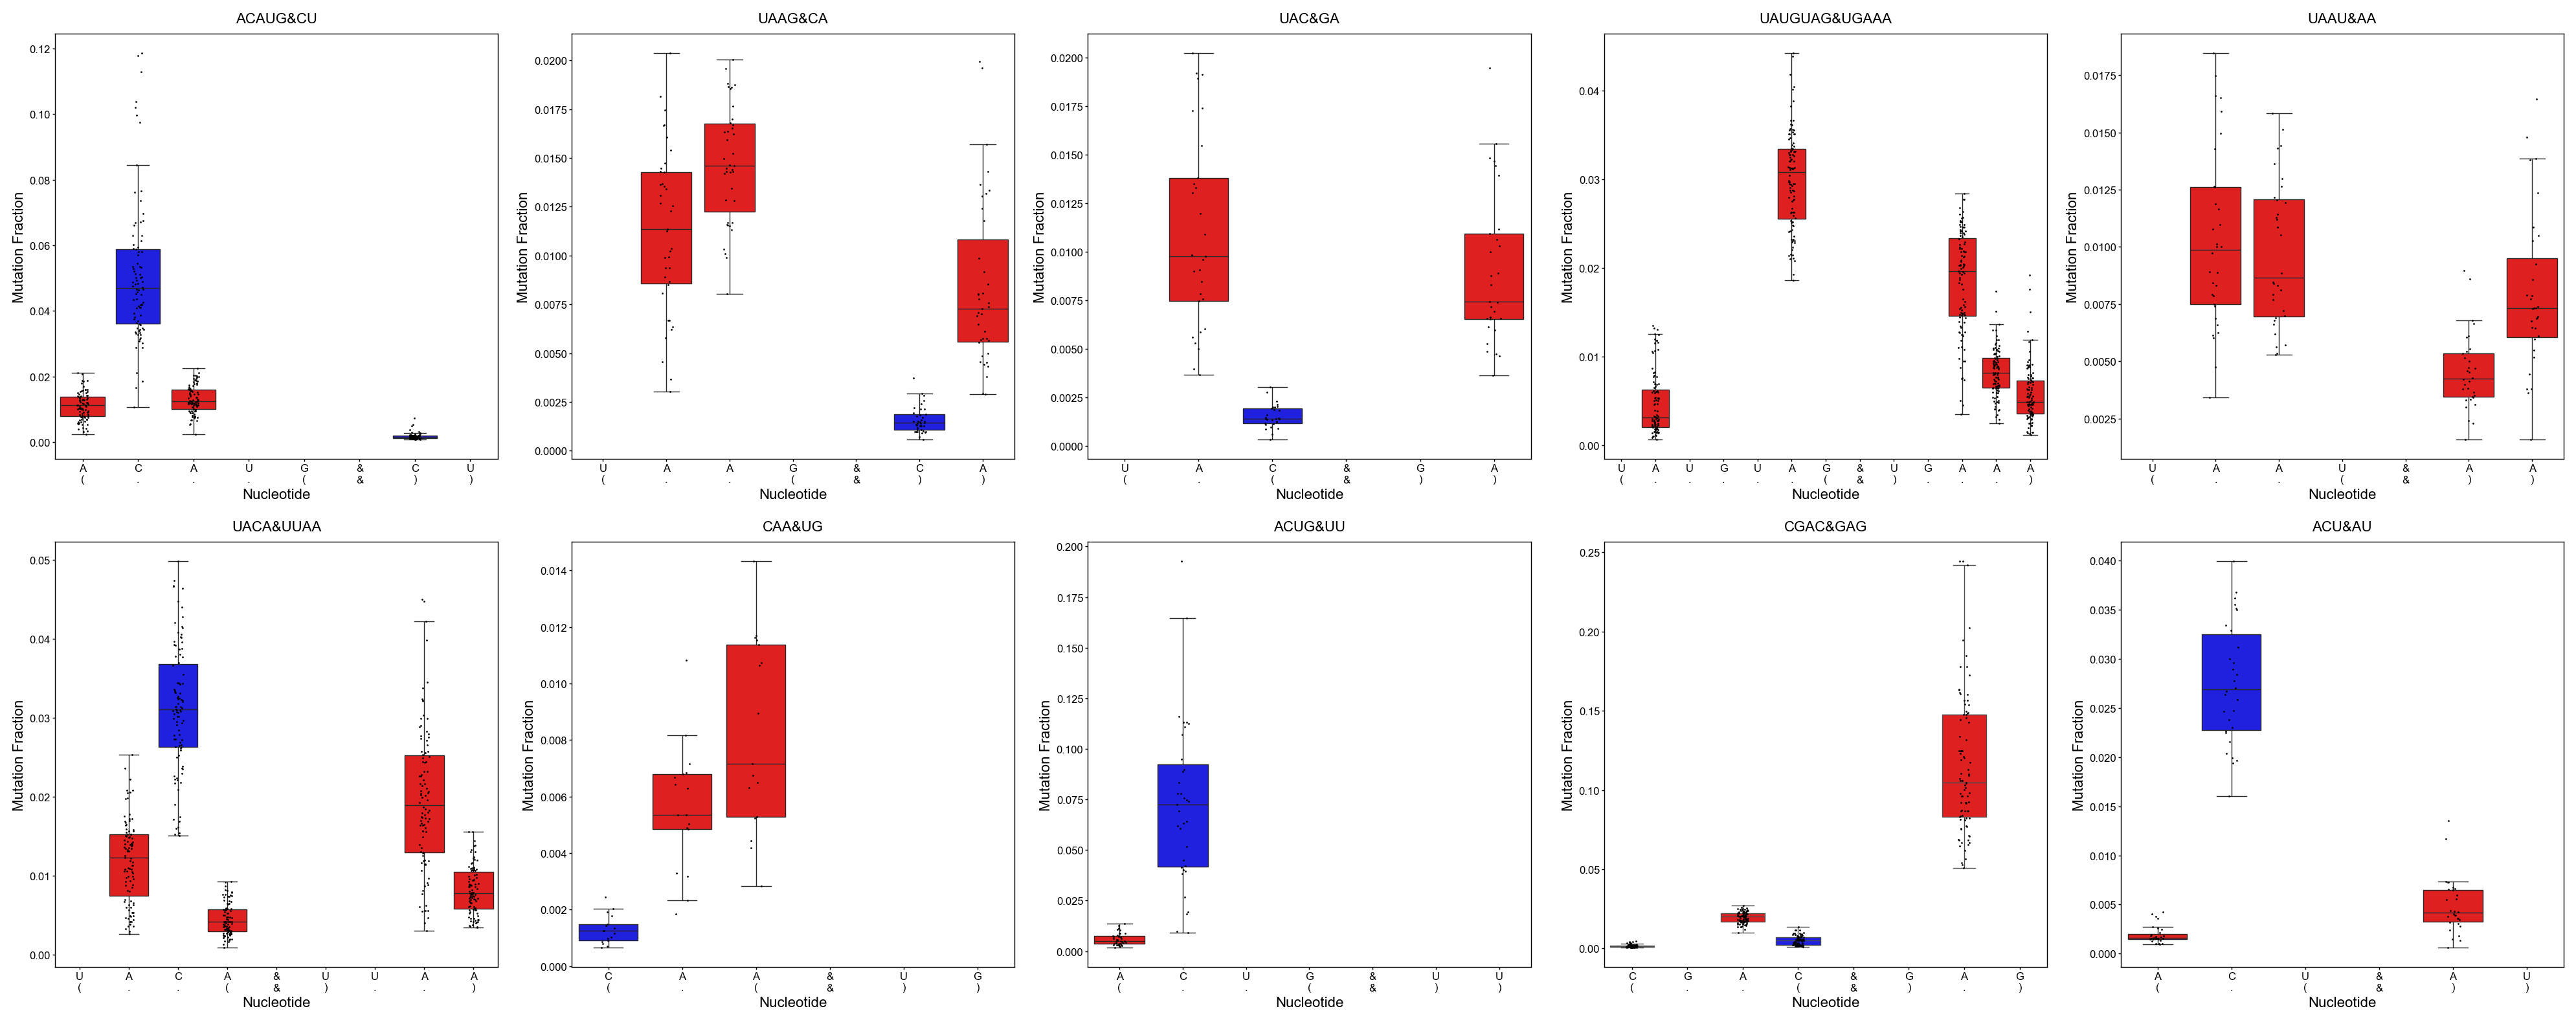

In [38]:
fig, axes = plt.subplots(2, 5, figsize=(20, 8), dpi=200)
axes = axes.flatten()

top_10_sequences = first_10_unique["m_sequence"].tolist()

for i, sequence in enumerate(top_10_sequences):
    if i < len(axes):  # Add this check to avoid index out of bounds error
        ax = axes[i]
        plot_motif_boxplot_stripplot(
            df.query(f"m_sequence == '{sequence}'"), ax=ax, show_structure=True
        )
        format_small_plot(ax)
        ax.set_title(sequence, fontsize=8)

# Remove any unused subplots
for j in range(len(top_10_sequences), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()  # Adjust the layout to prevent overlapping

#### AGGC&GAAU

In [39]:
df_wc.query("m_sequence == 'AGGC&GAAU' and r_loc_pos == 0 and ln_r_data > -5.45")

,both_purine,both_pyrimidine,constructs,has_pdbs,likely_pair,m_flank_bp_5p,m_flank_bp_3p,m_orientation,m_pos,m_second_flank_bp_5p,...,r_nuc,r_loc_pos,r_pos,r_type,r_stack,pdb_path,pdb_r_pos,ln_r_data,z_score,r_data_outlier
72614,True,False,construct949,False,AU,AU,CG,flipped,0,GC,...,A,0,105,WC,GG,[],3,-5.162040,0.717430,False
72627,True,False,construct1911,False,AU,AU,CG,flipped,2,AU,...,A,0,92,WC,AG,[],3,-5.197567,0.671191,False
72649,True,False,construct3320,False,AU,AU,CG,flipped,3,GC,...,A,0,83,WC,GG,[],3,-5.241937,0.615704,False
72605,True,False,construct147,False,AU,AU,CG,flipped,3,GC,...,A,0,84,WC,GG,[],3,-5.334981,0.507043,False
72685,True,False,construct6826,False,AU,AU,CG,non-flipped,1,GC,...,A,0,13,WC,GG,[],3,-5.368740,0.470052,False
72647,True,False,construct3027,False,AU,AU,CG,flipped,5,GC,...,A,0,70,WC,GG,[],3,-5.423881,0.412254,False


<Axes: >

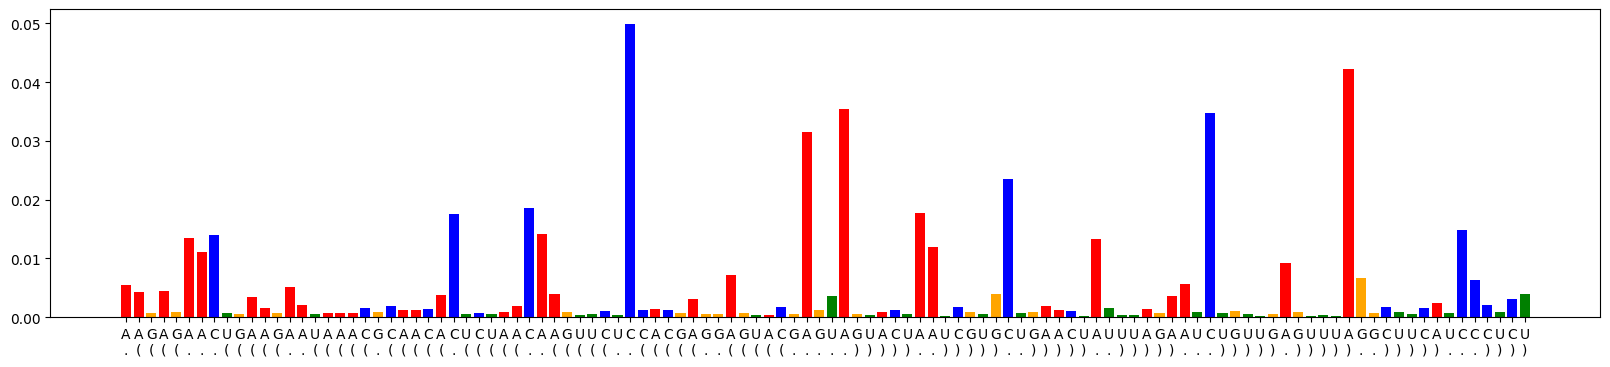

In [40]:
plot_pop_avg_from_row(df_constructs.query('name == "construct1191"').iloc[0])

<Axes: >

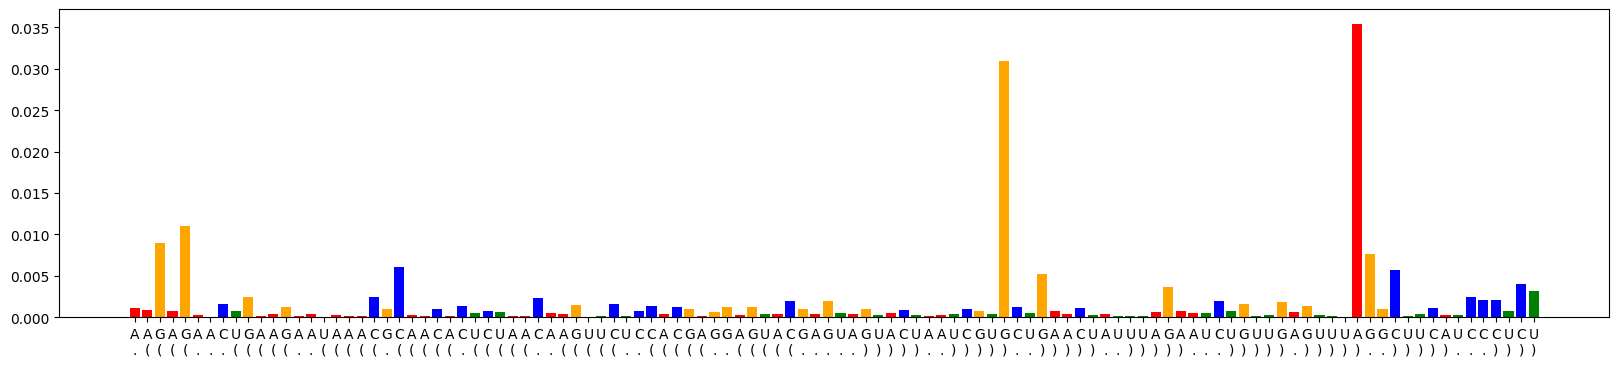

In [41]:
plot_pop_avg_from_row(df_constructs_nomod.query('name == "construct1191"').iloc[0])

In [42]:
df_constructs.query('name == "construct1191"').iloc[0]["sequence"]

'AAGAGAACUGAAGAAUAAACGCAACACUCUAACAAGUUCUCCACGAGGAGUACGAGUAGUACUAAUCGUGCUGAACUAUUUAGAAUCUGUUGAGUUUAGGCUUCAUCCCUCU'

<Axes: >

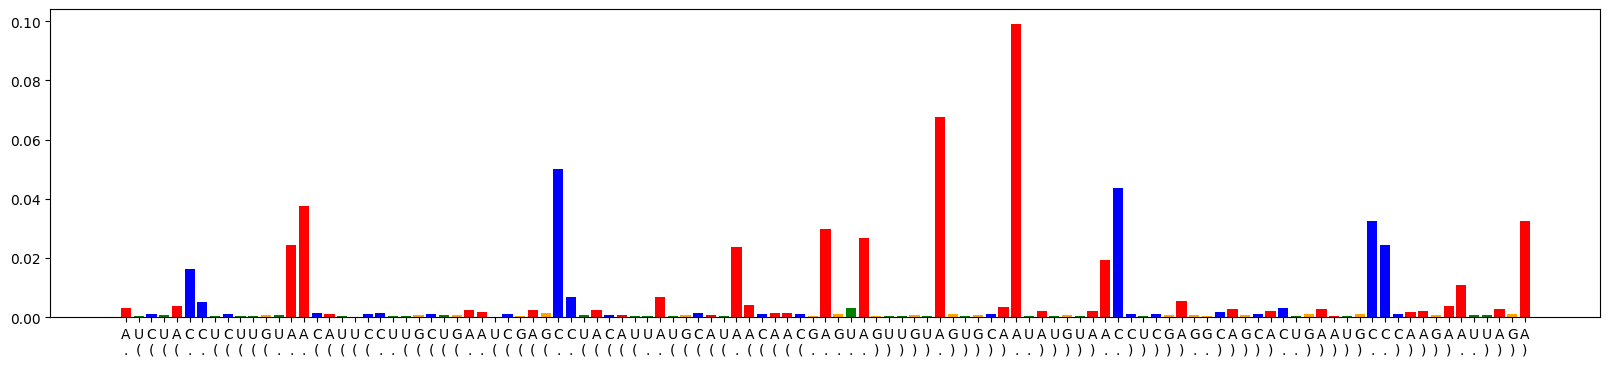

In [43]:
plot_pop_avg_from_row(df_constructs.query('name == "construct3320"').iloc[0])

<Axes: >

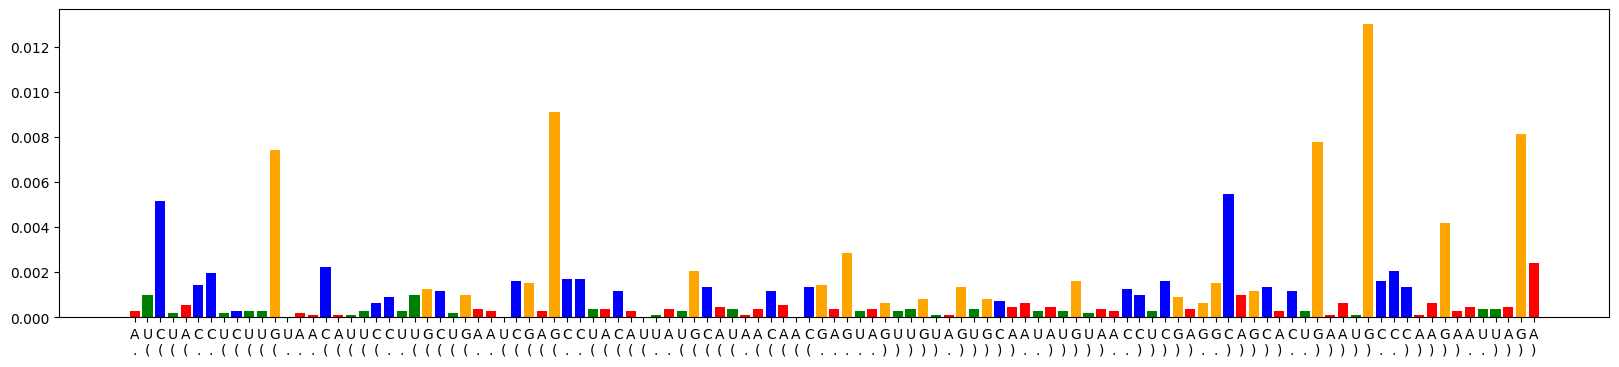

In [44]:
plot_pop_avg_from_row(df_constructs_nomod.query('name == "construct3320"').iloc[0])

In [45]:
df_pos = df_wc.query("m_sequence == 'AGGC&GAAU' and r_loc_pos == 0").copy()

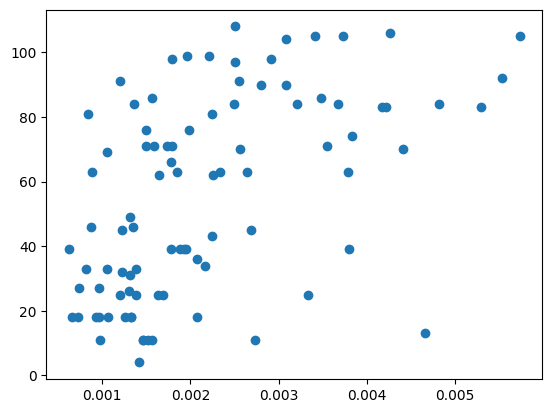

In [46]:
plt.scatter(df_pos["r_data"], df_pos["r_pos"])

#### AAAG&CCGU

In [47]:
df_wc.query("m_sequence == 'AAAG&CCGU' and r_loc_pos == 0 and ln_r_data < -5.45")

,both_purine,both_pyrimidine,constructs,has_pdbs,likely_pair,m_flank_bp_5p,m_flank_bp_3p,m_orientation,m_pos,m_second_flank_bp_5p,...,r_nuc,r_loc_pos,r_pos,r_type,r_stack,pdb_path,pdb_r_pos,ln_r_data,z_score,r_data_outlier
9121,False,False,construct5038,False,AU,AU,GC,flipped,2,UA,...,A,0,91,WC,UA,[],3,-5.453802,-0.923256,False
9123,True,False,construct5499,False,AU,AU,GC,flipped,1,AU,...,A,0,98,WC,AA,[],3,-5.475055,-0.938089,False
9104,True,False,construct2495,False,AU,AU,GC,flipped,5,GC,...,A,0,70,WC,GA,[],3,-6.019864,-1.228146,False
9092,False,False,construct884,False,AU,AU,GC,flipped,2,UA,...,A,0,91,WC,UA,[],3,-6.250235,-1.310548,False


(0.0, 0.05)

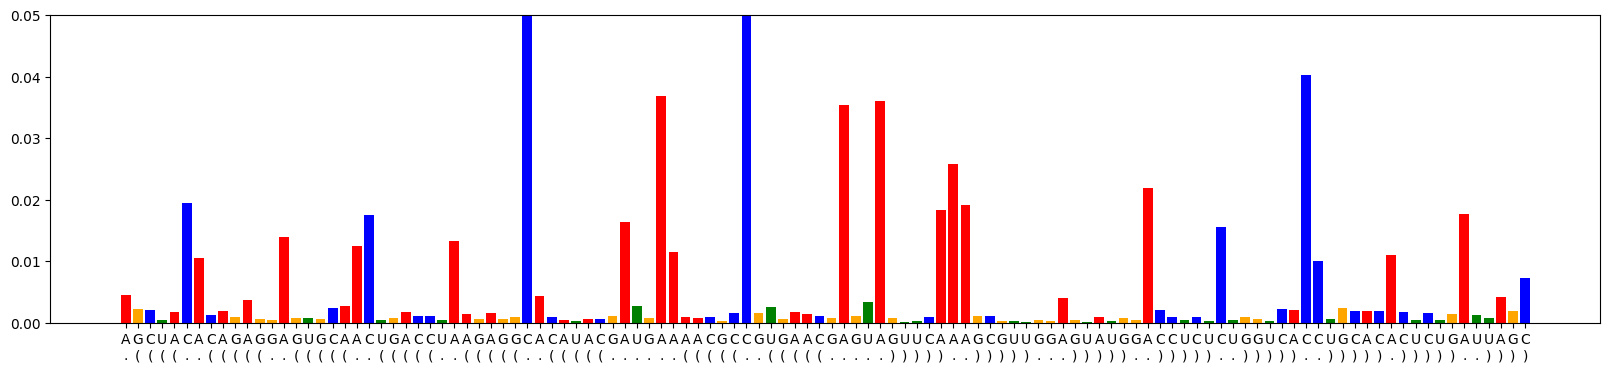

In [48]:
plot_pop_avg_from_row(df_constructs.query('name == "construct793"').iloc[0])
plt.ylim(0, 0.05)

<Axes: >

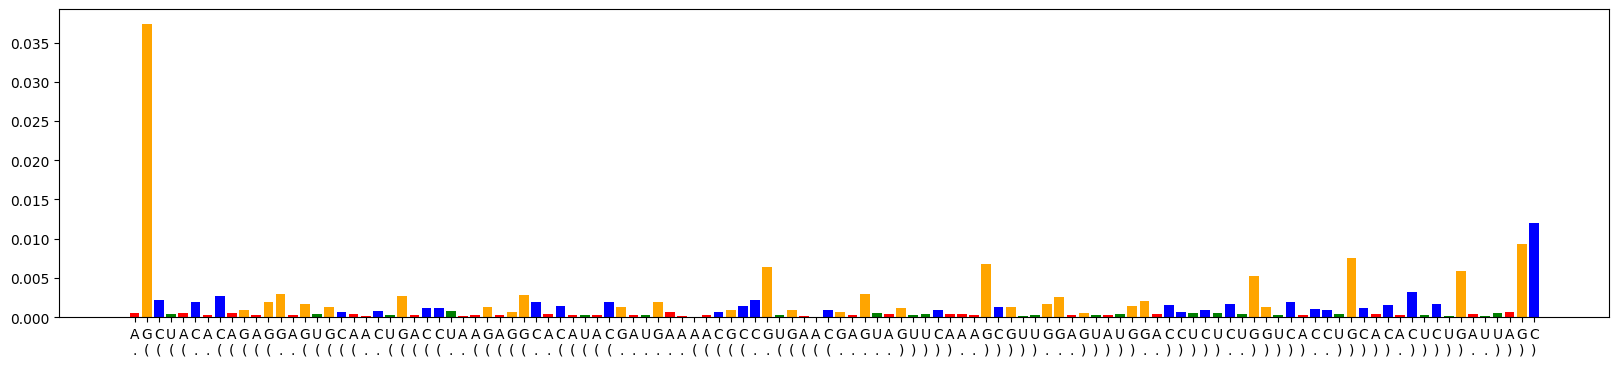

In [49]:
plot_pop_avg_from_row(df_constructs_nomod.query('name == "construct793"').iloc[0])

(0.0, 0.05)

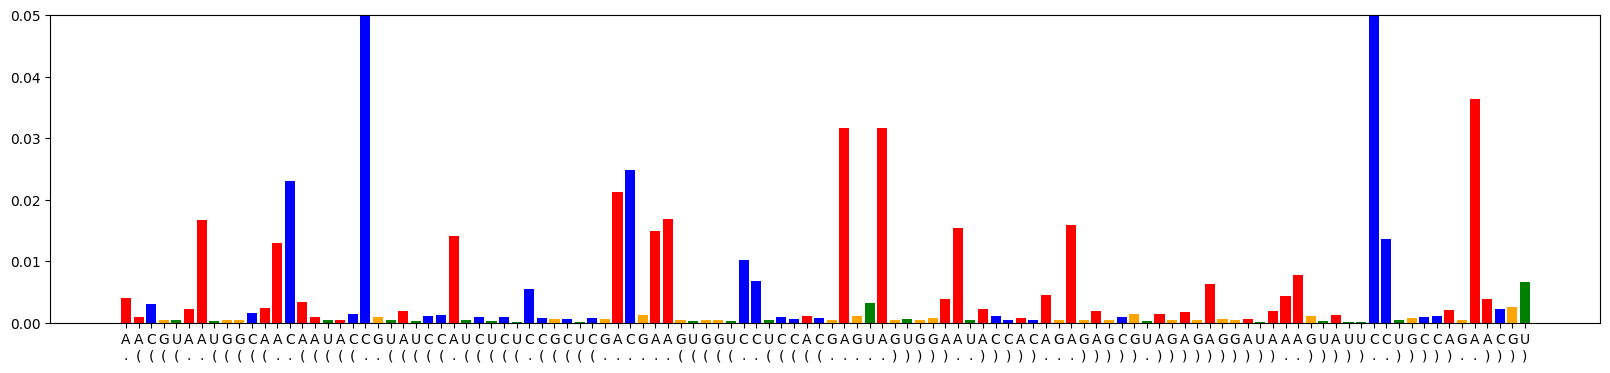

In [50]:
plot_pop_avg_from_row(df_constructs.query('name == "construct884"').iloc[0])
plt.ylim(0, 0.05)

<Axes: >

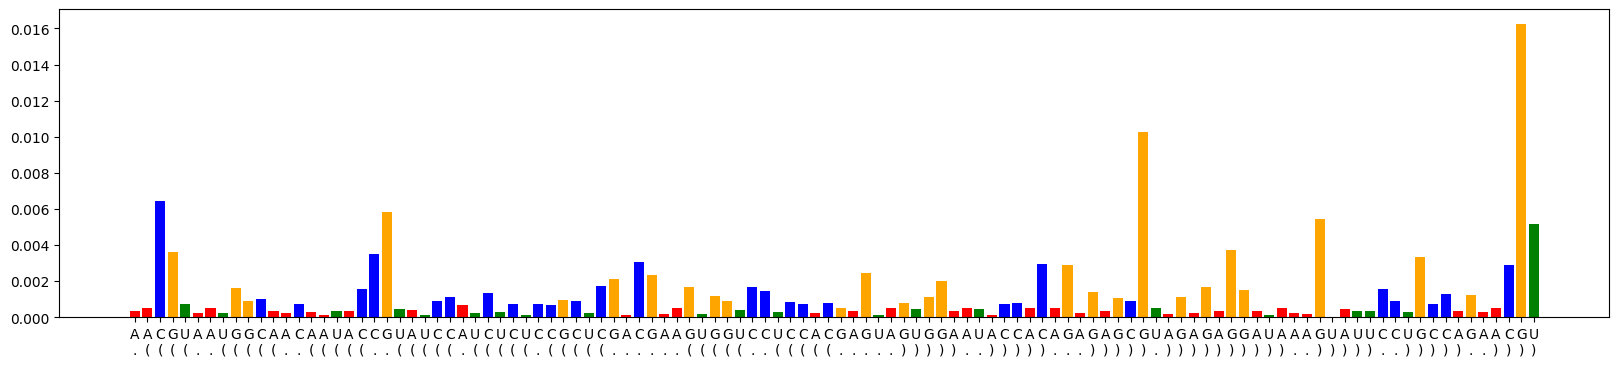

In [51]:
plot_pop_avg_from_row(df_constructs_nomod.query('name == "construct884"').iloc[0])